# BUILD PSTH OF ALL THE STIMULI

This code makes the psth for all the different stimuli that I have in the recordings.

The output will be a histo dictionary with branches containing all the spike times of every stimulus given.
The list will be empty if the stim was not in the protocol.

pickle output: histo_stims.pkl


In [ ]:
 %pylab inline

In [5]:
from pylab import *
from scipy import *
from scipy import stats, io
import numpy as np
import struct
from attrdict import AttrDict
import matplotlib.pyplot as plt
import os as os
from phy.io import KwikModel
import codecs as codecs
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mtick

import sys
sys.path.append('../functions') #this is where we put all the functions.py
from stim_loading import *
from save_load import *

In [2]:
#----------------------------------------------------------------------------------------
#SAVING BINARY OBJECTS DATA
#need to automate data folder creation
#----------------------------------------------------------------------------------------
import pickle 

def save_obj(obj, name ):
    with open( name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open( name + '.pkl', 'rb') as f:
        return pickle.load(f)

# FUNCTIONS TO BUILD PSTHs

In [223]:
#---------------------------------------------------------
# GET EPDURATION
#---------------------------------------------------------
def get_ep_duration(eptimefile):
    
    eptimesf = open(eptimefile, 'r')
    eptimes = [float(x)/30 for x in eptimesf.read().split()]
    eptimesf.close()
   
    return eptimes

#---------------------------------------------------------
# GET STIMTIMES
#---------------------------------------------------------
def get_stimtimes(stimfile,timefile):
    
    stims = open(stimfile, 'r')
    times = open(timefile, 'r')
    
    stimdata = stims.read().splitlines()
    timedata = times.read().splitlines()
 
    stims.close()
    times.close()
    
    return stimdata, timedata
#---------------------------------------------------------
# BUILD DICT STIM, reads stims and times of .txt files of experiments
#---------------------------------------------------------
def build_dict_stim(stimfile, timefile, epdurationfile):

    stims, times = get_stimtimes(stimfile,timefile)
    #------------------------------------------
    # count number of episodes
    episodes=1
    stims_ep=0
    for time in times[:-1]:             #last line is blank, we skip it
        if time == '': 
            episodes+=1
        if episodes ==1:
            stims_ep+=1
    print('Total episodes: ', episodes)        
    print('Total stims per episode: ', stims_ep)        
    #------------------------------------------
    # get episode duration
    ep_duration = get_ep_duration(epdurationfile)
    ####
    # for the formatting I have now:           #####################X   XXXXXXXXXXXXXXXXXX
    ep_length = ep_duration[6]
    
    ###
    #------------------------------------------
    # starting times of each stimulus
    starts = np.zeros([episodes, stims_ep])
    tot_stims = episodes*stims_ep

    st_count=0
    for t in times[:-1]:
        if t!='':
            st = st_count % stims_ep
            ep = st_count // stims_ep 
            starts[ep,st] = float(t) + ep*ep_length
            st_count+=1
    #------------------------------------------
    # stims        
    st_pad = zeros([episodes,stims_ep],dtype=integer) # 1 row, 2 arc, 3 pad
    st_types = zeros([episodes,stims_ep],dtype=integer) # 1 hold, 2 pass, 3 release        
    st_isi = zeros([episodes,stims_ep],dtype=integer) # 10 , 20, 50
    st_rep = zeros([episodes,stims_ep],dtype=integer) # 2, 5, 10
    st_ctrl = zeros([episodes,stims_ep],dtype=integer) # 0, blank, 1 ctrl1, 2 ctrl2, 3 ctrl3, 10 normal 
    # dictionary of stims
    st_logic = {} 
    st_logic['pad'] = {'1' : 'ROW' , '2' : 'ARC'  , '3': 'PAD' }
    st_logic['types'] = { '1':'hold', '2': 'pass'  , '3': 'release'}
    st_logic['ctrl'] = {'0' : 'BLANK', '1' : 'Ctrl1', '2' : 'Ctrl2', '3' : 'Ctrl3', '10' : 'Normal'}

    ep=0
    st=0
    # get stims
    for stim in stims[:-3]:           #last three lines useless
        line = stim.split()
        if line and ep<episodes:

            if line[1]=='BLANK':
                st+=1
                if st%stims_ep==0:
                    st=0
                    ep+=1
            elif len(line)>3:
                if line[1][1:4]=='ROW': st_pad[ep,st]=1
                elif line[1][1:4]=='ARC': st_pad[ep,st]=2
                elif line[1][1:4]=='PAD': st_pad[ep,st]=3

                if line[1][5:-1]=='Hold': st_types[ep,st]=1
                elif line[1][5:-1]=='Pass': st_types[ep,st]=2
                elif line[1][5:-1]=='Release': st_types[ep,st]=3

                if line[3]=='REP_2': st_rep[ep,st]=2
                elif line[3]=='REP_5': st_rep[ep,st]=5
                elif line[3]=='REP_10': st_rep[ep,st]=10

                if line[5]=='ISI_10': st_isi[ep,st]=10
                elif line[5]=='ISI_20': st_isi[ep,st]=20
                elif line[5]=='ISI_50': st_isi[ep,st]=50
                    
                if line[7]=='Normal': st_ctrl[ep,st]=10
                elif line[7][0:5]=='Ctrl1': st_ctrl[ep,st]=1
                elif line[7][0:5]=='Ctrl2': st_ctrl[ep,st]=2
                elif line[7][0:5]=='Ctrl3': st_ctrl[ep,st]=3
                elif line[7][0:5]=='Ctrl4': st_ctrl[ep,st]=4

                st+=1
                if st%stims_ep==0:
                    st=0
                    ep+=1

    Stim_dict = AttrDict({'st_logic':st_logic, 'episodes': episodes  ,'stims_ep':stims_ep  ,'st_times': starts})
    Stim_dict.update({'st_isi':st_isi,'st_rep':st_rep,'st_types':st_types,'st_ctrl': st_ctrl,'st_pad':st_pad})
    
    return Stim_dict

#----------------------------------------------------------------------------------------
# BUILD HIST DICTIONARY
#----------------------------------------------------------------------------------------
import copy as cp

def build_hist_dict():
    isis = [10,20,50]
    reps = [2,5,10]
    pads = ['ARC','ROW','PAD']
    types = ['hold','pass','release']
    
    Isis ={}
    for i in isis:
        Isis[i]= []
    
    Reps ={}
    for r in reps:
        Reps[r] = cp.deepcopy(Isis)
    
    Pads = {}
    for p in pads:
        Pads[p] = cp.deepcopy(Reps)
    
    Types = {}
    for t in types:
        Types[t] = cp.deepcopy(Pads)
    
    Normal = cp.deepcopy(Types)
    Ctrl1 = cp.deepcopy(Types)
    Ctrl2 = cp.deepcopy(Types)
    Ctrl3 = cp.deepcopy(Types)
    Ctrl4 = cp.deepcopy(Types)
    #----------------------------------------
    #for counnts
    Isisc ={}
    for i in isis:
        Isisc[i]= 0
    
    Repsc ={}
    for r in reps:
        Repsc[r] = cp.deepcopy(Isisc)
    
    Padsc = {}
    for p in pads:
        Padsc[p] = cp.deepcopy(Repsc)
    
    Typesc = {}
    for t in types:
        Typesc[t] = cp.deepcopy(Padsc)
        
    Normalc = cp.deepcopy(Typesc)
    
    counts_n = cp.deepcopy(Normalc)
    counts_c1 = cp.deepcopy(Normalc)
    counts_c2 = cp.deepcopy(Normalc)
    counts_c3 = cp.deepcopy(Normalc)
    counts_c4 = cp.deepcopy(Normalc)
    
    Counts ={}
    Counts['Normal'] = counts_n
    Counts['Ctrl1'] = counts_c1
    Counts['Ctrl2'] = counts_c2
    Counts['Ctrl3'] = counts_c3
    Counts['Ctrl4'] = counts_c4
    Counts['BLANK'] = 0
    
    hist_logic = 'Type x Pad x Rep x Isi'
    histo = AttrDict({ 'BLANK' :[],  'Normal': Normal, 'Ctrl1':Ctrl1 , 'Ctrl2':Ctrl2 , 'Ctrl3': Ctrl3, 'Ctrl4': Ctrl4 , 'hist_logic': hist_logic, 'Counts':Counts})

    return histo
    
#----------------------------------------------------------------------------------------
# READKWIKINFO
#----------------------------------------------------------------------------------------
# We read the data of the output from klusterkwik: spike times and cluster-number of each
# cluster-number is in klustaviewa series (can be as high as 130 e.g.)
# Grupete stands for cluster groups! 2: good clusters, 1: multiunits, 0: unsorted, 3: noise
def readkwikinfo(kwik, grupete=2):
    model = KwikModel(kwik) # load kwik model from file
    spiketimes = model.spike_times # extract the absolute spike times
    clusters = model.cluster_groups # extract the cluster names
    sample_rate = model.sample_rate # extract sampling freq
    
    spikedata = {} # initialise dictionary
    for cluster in clusters.keys():
        clustergroup = clusters[cluster]
        if clustergroup==grupete: # only look at specified type of cluster, 0 = noise, 1 = MUA, 2 = GOOD, 3 = unsorted
            spiketimematrix = AttrDict({'spike_times': np.zeros(len(spiketimes[where(model.spike_clusters==cluster)]))})
            spiketimematrix.spike_times = spiketimes[where(model.spike_clusters==cluster)]
            spikedata[cluster] = spiketimematrix # data structure is a dictionary with attribute accessible spiketimes
            # attribute accessible means that spikedata.spike_times works, normal dictionaries would be spikedata[spike_times]
    
    model.close()
    
    return spikedata, sample_rate

#----------------------------------------------------------------------------------------
# BUILDS PSTH
#----------------------------------------------------------------------------------------
def BuildPSTH(Stims, Spikes, sampling_freq, exp, meas):
    
    stimtimes = {}
    stim_samp = 1/.0009997575757
    # make an 'output dict'
    # the PSTH will be built on -tbefore:tafter
    PSTH_times = {}
    
    # Loop each neuron and get the spikes.
    for neuron in list(Spikes.keys()): 
        codename = 'exp'+ str(exp) + '_' + str(meas) + '_c' + str(neuron)
        psth = AttrDict({'clusnum': neuron,'exp' : int(exp) , 'meas': int(meas[1]) , 'shank': int(meas[3])})
        psth.update(AttrDict({'psth_counts': [] , 'psth_times': []}))
        
        histo= build_hist_dict()
        spikes = Spikes[neuron].spike_times*1000 #(want them in ms)
        
        print(spikes[0])
        print(spikes[-1])
        
        #loop episodes and stims_per_episode, and populate the histograms
        for ep in arange(Stims.episodes):
            for se in arange(Stims.stims_ep):
                
                code = str(int(Stims.st_ctrl[ep][se]))
                c = str(Stims.st_logic.ctrl[code])
                                
                if code=='0':
                    t_after=500
                    if len(spikes[(start <= spikes) * (spikes <= start + t_after)])>0:
                        histo[c].extend(spikes[(start <= spikes) * (spikes <= start + t_after)]-start)
                        histo['Counts'][c] +=  len(spikes[(start <= spikes) * (spikes <= start + t_after)])
                else:
                    code = str(int(Stims.st_types[ep][se]))                                                
                    t = str(Stims.st_logic.types[code])
                
                    code = str(int(Stims.st_pad[ep][se]))
                    p = Stims.st_logic.pad[code]
                    
                    r = Stims.st_rep[ep][se]
                    i = Stims.st_isi[ep][se]
                    start = Stims.st_times[ep][se]
                              
                    t_after = 500*r
                    if len(spikes[(start <= spikes) * (spikes <= start + t_after)])>0:
                        histo[c][t][p][r][i].extend(spikes[(start <= spikes) * (spikes <= start + t_after)]-start)
                        histo['Counts'][c][t][p][r][i]  += len((spikes[(start <= spikes) * (spikes <= start + t_after)]))
                                                       
        PSTH_times[codename] = histo
       
    return PSTH_times


In [ ]:
def Stimmaker(ctrl,types,rep,isi):
    
    base_stim = zeros(500)
    if 
    
    
    
    
    if ctrl ='Normal':
        stim = zeros(500*rep)
        
        
    
    
    
    

In [99]:
histo = build_hist_dict()

In [107]:
histo.Normalkeys()

dict_keys(['Ctrl1', 'Ctrl4', 'Blank', 'hist_logic', 'Ctrl3', 'Ctrl2', 'Normal', 'Counts'])

In [14]:
Folder = '/media/matias/DATA/WORKSPACE2/EXP_2'        
stimfile = Folder +'/EXPECT-151217-stims-7.txt'   
timefile = Folder +'/EXPECT-151217-times-7.txt'   
epfile = Folder +'/EXPECT-151217-ep_times-7.txt'   

Stims = build_dict_stim(stimfile, timefile, epfile)

print(Stims.keys())

h = build_hist_dict()

print(h.keys())
print(h.hist_logic)

print(Stims.st_logic)

Stims.st_rep.shape

Stims.stims_ep


Total episodes:  15
Total stims per episode:  28
dict_keys(['st_rep', 'st_types', 'st_logic', 'stims_ep', 'st_times', 'episodes', 'st_ctrl', 'st_isi', 'st_pad'])
dict_keys(['Ctrl3', 'Normal', 'Blank', 'hist_logic', 'Ctrl2', 'Ctrl4', 'Counts', 'Ctrl1'])
Type x Pad x Rep x Isi
AttrDict({'pad': {'3': 'PAD', '1': 'ROW', '2': 'ARC'}, 'ctrl': {'0': 'BLANK', '3': 'Ctrl3', '10': 'Normal', '1': 'Ctrl1', '2': 'Ctrl2'}, 'types': {'3': 'release', '1': 'hold', '2': 'pass'}})


28

In [26]:
print(h.keys())

print(h.hist_logic)


h.Normal.HOLD.ROW[2][10]

dict_keys(['Ctrl1', 'Ctrl4', 'Blank', 'hist_logic', 'Ctrl3', 'Ctrl2', 'Normal', 'Counts'])
Type x Pad x Rep x Isi


[]

# Experiment Files and Folders

In [137]:
# In this cell you put all the information to make the code portable from computer to computer
# You have to place all the file names and experiments, then you loop whichever you want to analyse
#--------------------------------------------------------------------------------
#Experiment numbers
ExpeNum = [1,2]
#--------------------------------------------------------------------------------
#Folders for measurements and experiments (this is how we separate shanks in folders for individual analyses)
m164 = ['m1s'+str(s) for s in arange(8)+1]
m264 = ['m2s'+str(s) for s in arange(8)+1]
m364 = ['m3s'+str(s) for s in arange(8)+1]
m464 = ['m4s'+str(s) for s in arange(8)+1]
m564 = ['m5s'+str(s) for s in arange(8)+1]
m664 = ['m6s'+str(s) for s in arange(8)+1]
m764 = ['m7s'+str(s) for s in arange(8)+1]
m864 = ['m8s'+str(s) for s in arange(8)+1]
m964 = ['m9s'+str(s) for s in arange(8)+1]
m1064 = ['m10s'+str(s) for s in arange(8)+1]

M = [m164,m264,m364,m464,m564,m664,m764,m864,m964,m1064]

shanks = ['_ele01_ele08.kwik',
          '_ele09_ele16.kwik',
          '_ele17_ele24.kwik',
          '_ele25_ele32.kwik',
          '_ele33_ele40.kwik',
          '_ele41_ele48.kwik',
          '_ele49_ele56.kwik',
          '_ele57_ele64.kwik']
#--------------------------------------------------------------------------------
#--------------------------------------------------------------------------------
#Kwik files    
base = {}
files = {}
#--------------------------------------------------------------------------------
exp = 1
base[exp] = ['EXPECT-151029-'+str(i) for i in arange(10)+1]
files[exp] ={}
for reps in arange(10):
    files[exp][reps+1] = [ base[exp][reps]+shanks[i] for i in arange(8)]
#--------------------------------------------------------------------------------
exp = 2
base[exp] = ['EXPECT-151217-'+str(i) for i in arange(10)+1]
files[exp] ={}
for reps in arange(7):
    files[exp][reps+1] = [ base[exp][reps]+shanks[i] for i in arange(8)]

#--------------------------------------------------------------------------------
# Here I create my dictionary of experiments
Expe={}
for num in ExpeNum: 
    Expe[num] = dict()
#---------------------------------------
stimfiles = {}
timefiles = {}
eptimefiles = {}

exp =1
m=0
for Meas in M[0:10]:
    i=0
    for meas in Meas:
        Expe[exp][meas] = files[exp][m+1][i]
        i+=1
    m+=1
exp=2
m=0
for Meas in M[0:7]:
    i=0
    for meas in Meas:
        Expe[exp][meas] = files[exp][m+1][i]
        i+=1
    m+=1

#--------------------------------------------------------------------------------
#Stim files
for exp in ExpeNum:
    stimfiles[exp] = [base[exp][rep-1][:-1] + 'stims-' + str(rep) + '.txt' for rep in files[1]]
    timefiles[exp] = [base[exp][rep-1][:-1] + 'times-' + str(rep) + '.txt' for rep in files[1]]
    eptimefiles[exp] = [base[exp][rep-1][:-1] + 'ep_times-' + str(rep) + '.txt' for rep in files[1]] 

# Define and load data files from experiments

In [224]:
global binname, textname
#---------------------------------------------------------------------------------------
SelExp = [2]                         #select experiment numbers!
grupete = [2]   #select cluster groups! 2 for good clusters 1 for multiunits, 3 for unsorted

#select measurement and/or shanks!
Measurements = m764[0:1]           #['m1s1']#['m3s1','m3s3']#m12[-4:]#['m1s1','m1s2','m1s3','m1s4']   

rootF = '/media/matias/DATA/WORKSPACE2/'    

dirs =[]
#--------------------------------------------------------------------------------
# Loop Experiments
#--------------------------------------------------------------------------------
last_exp=0     #we use this to load stim only when we change experiment
for expe in SelExp:
    
    PSTHdata = {}
    PSTH_spikes_counts = {}
    
    #Measurements = sorted(Expe[expe])                         #uncommento to select all
    print(expe)
   
    last_meas =0   #we use this to find when we change measurement to load Vtag and stim again
    
    #--------------------------------------------------------------------------------
    #loop goodunits, multiunits, unsorted...
    for group in grupete:   #2 for good clusters 1 for multiunits 3 for unsorted
        #folder names
        if group ==3:
            dirs  = [rootF + 'OUTPUT/EXP_'+str(expe)]
        if group ==2:
            dirs  = [rootF + 'OUTPUT/EXP_'+str(expe)]
        if group ==1:
            dirs  = [rootF + 'OUTPUT/EXP_'+str(expe)]
        #--------------------------------------------------------------------------------
        #create output folders
        for dir in dirs:
            if not os.path.exists(dir):
                os.makedirs(dir) 
        dire = dirs[0] +'/'
        titles = 'Exp'+ str(expe) + '_Meas_' + meas[1] + '_Shank_' + meas[3]
        #--------------------------------------------------------------------------------
        print('group:', group)
        #--------------------------------------------------------------------------------
        #loop measurements and shanks
        #Measurements = sorted((Expe[expe]))
        
        for meas in Measurements:           
            print(meas)
            current_meas = int(meas[1])   #measurement number
            #---------------------------------------------------------------
            #This is to account for diffrerent stims when looping diffrerent experiments
            if current_meas!=last_meas:
                stimfile = rootF + 'EXP_' + str(expe) + '/' + stimfiles[expe][current_meas-1]
                timefile = rootF + 'EXP_' + str(expe) + '/' +timefiles[expe][current_meas-1]
                epfile = rootF + 'EXP_' + str(expe) + '/' +eptimefiles[expe][current_meas-1]
                
                Stims = build_dict_stim(stimfile, timefile, epfile)
          
            
            #select datafile
            sp_file = rootF + 'EXP_' + str(expe) +'/Spike_Sort/'+ meas +'/'+ Expe[expe][meas]
            #load datafile
            Spikes, sampling_freq = readkwikinfo(sp_file, group)  
                    
            if len(Spikes.keys())>0:                              #do only if there are clusters
                #Build PSTHs
                print('   building psths')
    
                PSTH_data = BuildPSTH(Stims, Spikes, sampling_freq, exp, meas) 
               
    print('   saving')
    if group == 2:
        filesave =rootF +'Expect_git/data/'+'psthdata' + str(expe)
    else:
        filesave =rootF +'S2_git/data/'+ 'psthdataMultiR' + str(expe)
        
    #save_obj(PSTHdata,filesave)

2
group: 2
m7s1
Total episodes:  15
Total stims per episode:  28
   building psths
67074.6666667
1169623.53333
3130.4
1169626.73333
34072.5333333
1171119.06667
3071.43333333
1170640.83333
360.1
1171028.9
24783.5
1166739.5
   saving


['exp2_m7s1_c2', 'exp2_m7s1_c7', 'exp2_m7s1_c6', 'exp2_m7s1_c3', 'exp2_m7s1_c14', 'exp2_m7s1_c13']
dict_keys(['Ctrl3', 'Normal', 'hist_logic', 'Ctrl2', 'Ctrl4', 'Counts', 'Ctrl1', 'BLANK'])


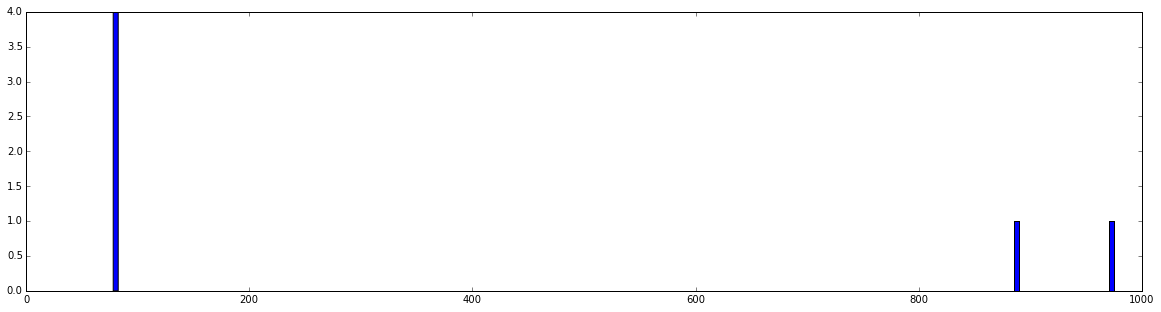

In [305]:
idx = list(PSTH_data.keys())
print(idx)

ps = PSTH_data
n = idx[3]

print(ps[n].keys())

ps[n].Normal.keys()

fig = figure(figsize=(20,5))

n1 =hist(ps[n].Normal.hold.ARC[2][10], bins=200)

#ps[n].Normal.hold


dict_keys(['st_times', 'st_types', 'st_rep', 'stims_ep', 'episodes', 'st_pad', 'st_logic', 'st_isi', 'st_ctrl'])


-5104.1333333335351

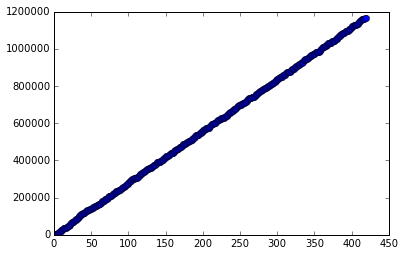

In [52]:
print(Stims.keys())

a=[]
for i in arange(15):
    a.extend(Stims.st_times[i])
    
plot(a,'o')
a[-1]-1171000


In [382]:
hist

<function matplotlib.pyplot.hist>

In [34]:
#filesave

sorted(list(PSTHdata.keys()))
PSTHdata['exp20_m1s1_c29'].keys()

data = rootF +'S2_git/data/'+'psthdata' + str(22)

a = load_obj(data)

a['exp22_m3s4_c1138'].keys()

dict_keys(['psth_counts', 'meas', 'psth_length', 'clusnum', 'psth_times', 'exp', 'shank'])

In [ ]:
#update spiketimes to wavedataAll
SelExp = [20] #[22,24,26,27,28,29,30,31,32] #Expe                                        #select experiment numbers!

Folder = '/home/matias/WORKSPACE/S2_git/data'    

for e in SelExp:

    data = Folder +'/wavedata'+ str(e)
    wavedata = load_obj(data)

    idx = list(wavedata.keys())

    datapsth = Folder +'/psthdata' + str(e)
    psthdata = load_obj(datapsth)


    for n in idx:
        wavedata[n].update(psthdata[n])    
            
    data = Folder +'data/datamix' + str(e)

    save_obj(wavedata, data)



In [ ]:
idx = list(PSTHdata.keys())
PSTHdata[idx[0]].keys()
#PSTHdata[idx[0]]


In [ ]:
Spikes.keys()

In [ ]:
PSTHdata[idx[0]][1]